# Climate Change Case Study

### FNCE 3436
#### Laura Klipp, Hale Tussing, Victor Yu


# Background

Is climate change real or fake?  We'll look at North American meteorological data compiled by SCU's own [Prof Maurer](http://www.engr.scu.edu/~emaurer/gridded_obs/index_gridded_obs.html).  The website contains **daily** and **monthly** data at ~60,000  equally spaced measurement locations across the continental United States, Mexico, and part of Canada.

*Ref: Maurer, E.P., A.W. Wood, J.C. Adam, D.P. Lettenmaier, and B. Nijssen, 2002, A Long-Term Hydrologically-Based Data Set of Land Surface Fluxes and States for the Conterminous United States, J. Climate 15, 3237-3251.*

![temp](./ldas_allbas.gif)

# Region Names

7) **ark** : Arkansas - Red
2) **cali** : California
4) **color** : Colorado River
1) **crb** : Northwest and Columbia
13) **east** : East Coast
9) **glakes** : Great Lake Dainage
3) **grb** :  Great Basin
8) **gulf** : South Central (Gulf)
11) **low** : Lower Mississippi
15) **mex** : Mexico
6) **mo** : Missouri River
12) **ohio** : Ohio
5) **rio** : Rio Grande
10) **up** : Upper Mississippi

In [60]:
import pandas as pd
import numpy as np
import os
from os import listdir
from os.path import isfile, join
import sqlite3
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - MAIN - [%(name)s] [%(levelname)s] : %(message)s')
import sys
import functools
import operator
%matplotlib inline
import matplotlib.pyplot as plt

# Forming a SQLite Database 

In [19]:
def get_conn(host='sanjose',user='student',db='atlas'):
    cmd = "host=%s user=%s dbname=%s " % (host, user, db)
    try:
        db = psycopg2.connect(cmd)
        return db
    except:
        logging.warning('unable to connect to psql db : %' % cmd)
        sys.exit(1)
        
def setup_db(db_name):
    assert DB_DIR == '../db/'
    files = os.listdir('..')
    if 'db' not in files:
        os.mkdir(DB_DIR)
        logging.info('created directory: %s' % DB_DIR)
    files = os.listdir(DB_DIR)
    if db_name not in files:
        logging.info('creating db: %s' % db_name)
        conn = sqlite3.connect(DB_DIR + db_name, check_same_thread=False, timeout=3000)
        conn.close()

def create_table(db_name, table_name, columns, types):
    head = ', '.join(['%s %s' % (c_t[0],c_t[1]) for c_t in zip(columns, types)])
    db = sqlite3.connect(DB_DIR + db_name, check_same_thread=False, timeout=3000)

    c = db.cursor()        
    
    sql_stmt = "CREATE TABLE %s (%s)" % (table_name, head)
    logging.info(sql_stmt)
    c.execute(sql_stmt)

    db.commit()
    db.close()
        
DATA_DIR = '../data/'
DB_DIR = '../db/'
conn = sqlite3.connect('climate_data.db', check_same_thread=False, timeout=3000)

db_name = 'climate_data.db'
table_name = 'region_monthly_weather'
columns =["region", "latitude", "longitude", "year", "month", "total_precipitation", "max_temp", "min_temp", "wind"]
types = ['TEXT','REAL','REAL','INTEGER','INTEGER','REAL','REAL','REAL','REAL']

setup_db(db_name)

create_table(db_name, table_name, columns, types)

2019-09-30 11:20:37,467 - MAIN - [root] [INFO] : creating db: climate_data.db
2019-09-30 11:20:37,471 - MAIN - [root] [INFO] : CREATE TABLE region_monthly_weather (region TEXT, latitude REAL, longitude REAL, year INTEGER, month INTEGER, total_precipitation REAL, max_temp REAL, min_temp REAL, wind REAL)


In [20]:
def pair(filepath):
    region=[filepath.split('/')[-2]]
    region_file = os.fsencode(filepath)
    feilds=["region", "latitude", "longitude", "year", "month", "total_precipitation", "max_temp", "min_temp", "wind"]
    
    a= []
    for file in os.listdir(region_file):
        filename = os.fsdecode(file)
        lat_lon = filename.split('_')[1:]
        open_file = open(filepath+filename,'r')
        contents = open_file.readlines()
        for i in range(len(contents)):
            a.append(dict(zip(feilds,region+lat_lon+(contents[i].split()))))
    return a

def list_reduce(a):
    return functools.reduce(operator.iconcat, a, [])

def execute(Statement):
    connection  = sqlite3.connect(DB_DIR + db_name, 
                                  check_same_thread=False, 
                                  timeout=3000)
    cursor      = connection.cursor()
    cursor.execute(Statement)
    connection.close()
    
def query(db_name, sql_stmt, columns=None):
    logging.info(sql_stmt)
    db = sqlite3.connect(DB_DIR + db_name, check_same_thread=False, timeout=3000)
    cursor = db.cursor()
    tmp = cursor.execute(sql_stmt)
    result = tmp.fetchall()
    db.close()
    logging.info('found: %d lines' % len(result))
    if columns:
        return [dict(list(zip(columns, x))) for x in result]
    else:
        return result
    
def insert(table_name, record, cursor):
    columns = list(record.keys())
    values = []
    for v in record.values():
        if type(v) == str:
            values += ["'%s'" % v]
        else:
            values += ['%s' % v]
    sql_stmt = 'INSERT INTO %s (%s) VALUES (%s)' % (table_name, ','.join(columns), ','.join(values))
    cursor.execute(sql_stmt)
    
def post(db_name, table_name, records):
    sql_stmt = "select count(*) from %s" % table_name
    raw = query(db_name, sql_stmt, columns=['count'])
    logging.info('found: %s' % raw)
    if raw[0]['count'] == 0:
        logging.info('posting: %d lines' % len(records))
        db = sqlite3.connect(DB_DIR + db_name, check_same_thread=False, timeout=3000)
        cursor = db.cursor()
        for r in records:
            insert(table_name, r, cursor)
        db.commit()
        db.close()
        logging.info('posted: %d lines' % len(records))
    else:
        logging.info('posted: 0 lines')
        logging.warning('this function is configured to avoid posting to a table more than once')

In [21]:
file_path = os.fsdecode("/Users/LauraKlipp/Dropbox/School/Fall_2/Time_Series/Climate_Change_Case_Study/Climate_data/")

In [22]:
all_data=[]

for file in os.listdir(file_path):
    if str(file)!='.DS_Store':
        list_= pair(file_path+file+"/")
        all_data.append(list_)
        
all_data_list = list_reduce(all_data)

post(db_name, table_name, all_data_list)

2019-09-30 11:30:17,346 - MAIN - [root] [INFO] : select count(*) from region_monthly_weather
2019-09-30 11:30:17,401 - MAIN - [root] [INFO] : found: 1 lines
2019-09-30 11:30:17,403 - MAIN - [root] [INFO] : found: [{'count': 0}]
2019-09-30 11:30:17,408 - MAIN - [root] [INFO] : posting: 44884776 lines
2019-09-30 11:55:00,735 - MAIN - [root] [INFO] : posted: 44884776 lines


## Querying Data from SQLite / Data Visualization

1) Average max and min temperatures aggregated at each month/year to show average seasonality over time

2) Total precipitation per year over time

3) Min and Max temperature seasonality over time

### Temperature over time

In [96]:
max_min_temp_year = query('climate_data.db', \
                          'select year, avg(max_temp), avg(min_temp)\
                           from region_monthly_weather \
                           group by year', columns=None)

2019-09-30 14:28:07,568 - MAIN - [root] [INFO] : select year, avg(max_temp), avg(min_temp)                           from region_monthly_weather                            group by year
2019-09-30 14:28:51,730 - MAIN - [root] [INFO] : found: 62 lines


In [131]:
df_max_min_temp_year = pd.DataFrame(max_min_temp_year)
df_max_min_temp_year.columns=['year', 'avg_max_temp', 'avg_min_temp']
df_max_min_temp_year = df_max_min_temp_year.set_index('year')

#### Maximum Temperature (C) Over Time

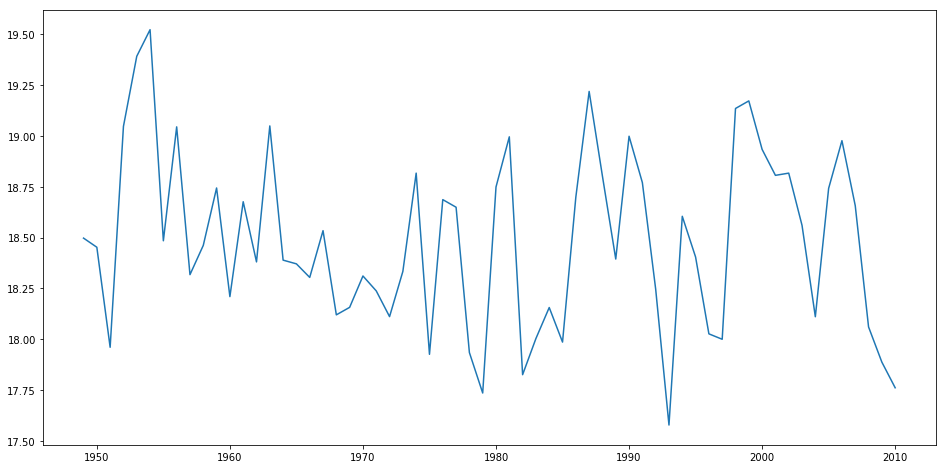

In [133]:
plt.figure(figsize=(16,8))
plt.plot(df_max_min_temp_year['avg_max_temp'])

#### Minimum Temperature (C) Over Time

Text(0, 0.5, 'Temperature (C)')

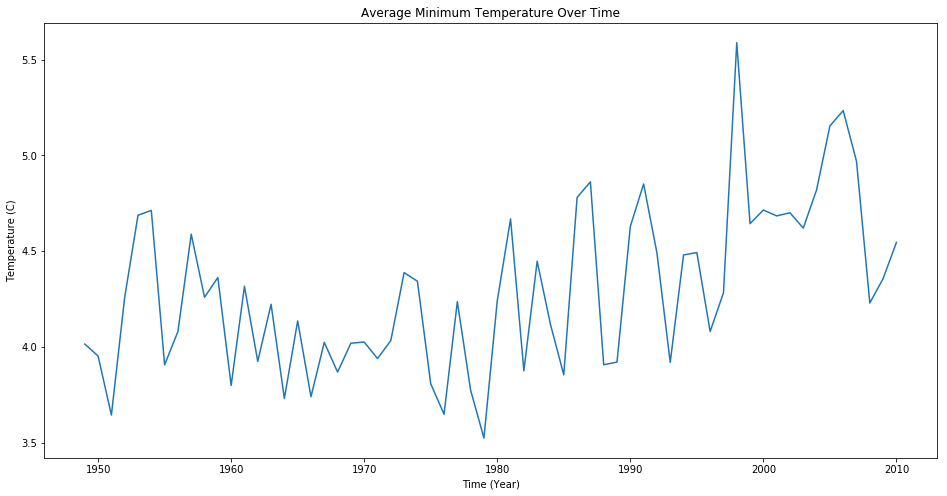

In [139]:
plt.figure(figsize=(16,8))
plt.plot(df_max_min_temp_year['avg_min_temp'])
plt.title('Average Minimum Temperature Over Time')
plt.xlabel('Time (Year)')
plt.ylabel('Temperature (C)')

#### Total Precipitation over time

In [120]:
tot_precip_year = query('climate_data.db', \
                          'select year, sum(total_precipitation)\
                           from region_monthly_weather \
                           group by year', columns=None)

2019-09-30 14:55:26,119 - MAIN - [root] [INFO] : select year, sum(total_precipitation)                           from region_monthly_weather                            group by year
2019-09-30 14:56:06,535 - MAIN - [root] [INFO] : found: 62 lines


In [121]:
df_tot_precip_year = pd.DataFrame(tot_precip_year)
df_tot_precip_year.columns=['year', 'total_precipitation']
df_tot_precip_year = df_tot_precip_year.set_index('year')

Text(0, 0.5, 'Precipitation (mm)')

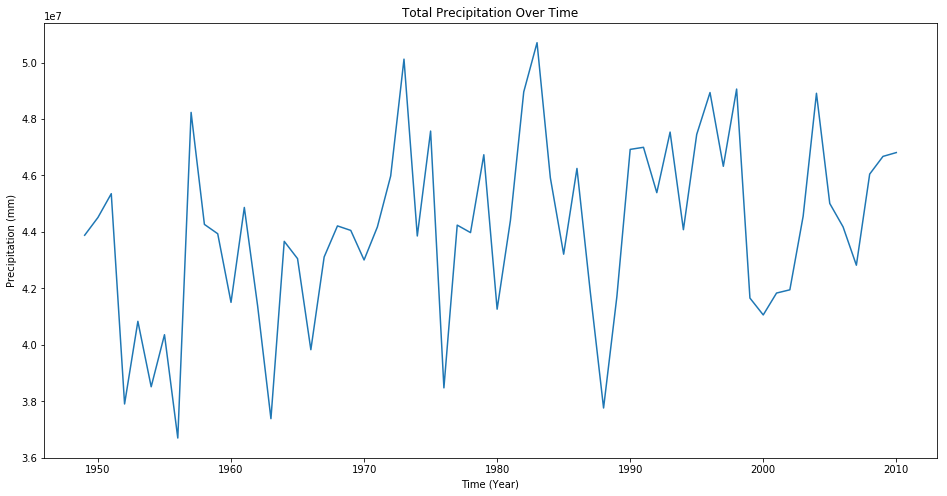

In [138]:
plt.figure(figsize=(16,8))
plt.plot(df_tot_precip_year)
plt.title('Total Precipitation Over Time')
plt.xlabel('Time (Year)')
plt.ylabel('Precipitation (mm)')

#### Seasonality of Min and Max temp over time

In [89]:
max_min_temp_yearmonth = query('climate_data.db', \
                               'select year, month, avg(max_temp), avg(min_temp)\
                                from region_monthly_weather \
                                group by year, month', columns=None)

2019-09-30 14:16:10,107 - MAIN - [root] [INFO] : select year, month, avg(max_temp), avg(min_temp)                                from region_monthly_weather                                 group by year, month
2019-09-30 14:17:12,399 - MAIN - [root] [INFO] : found: 744 lines


In [92]:
df_max_min_temp_yearmonth = pd.DataFrame(max_min_temp_yearmonth)
df_max_min_temp_yearmonth.columns=['year', 'month', 'avg_max_temp', 'avg_min_temp']
df_max_min_temp_yearmonth['year_month']=df_max_min_temp_yearmonth[["year","month"]].apply(lambda x: str(x[0])+'/'+str(x[1]), axis=1).astype(np.datetime64)
df_max_min_temp_yearmonth = df_max_min_temp_yearmonth[['year_month', 'avg_max_temp', 'avg_min_temp']].set_index('year_month')
df_max_min_temp_yearmonth.head()

,avg_max_temp,avg_min_temp
year_month,,
1949-01-01,3.007712,-8.816704
1949-02-01,6.910965,-6.255433
1949-03-01,12.052825,-1.207242
1949-04-01,19.210232,3.720710
1949-05-01,24.225585,8.983065


Text(0, 0.5, 'Temperature (C)')

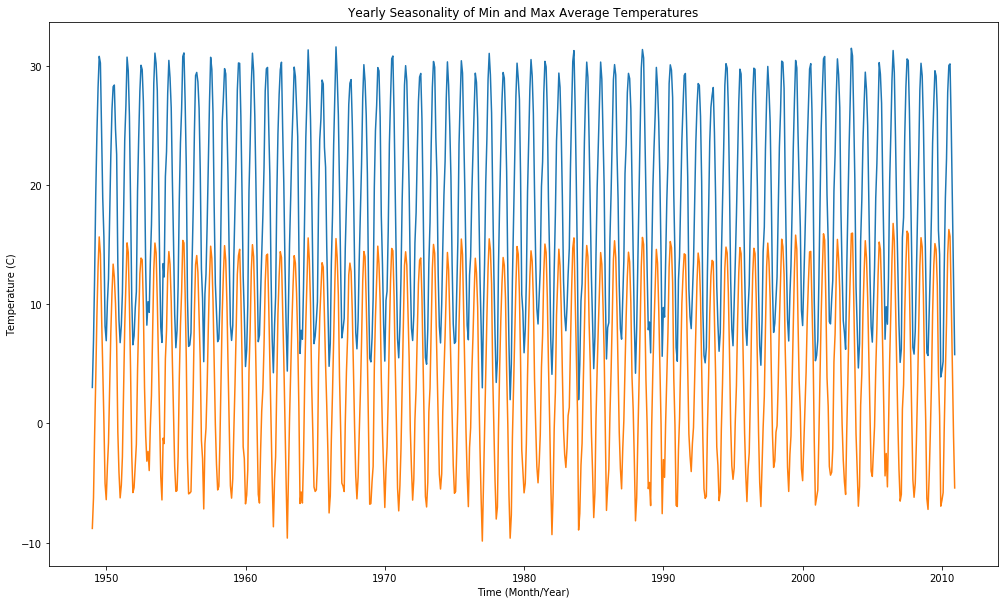

In [136]:
plt.figure(figsize=(17,10))
plt.plot(df_max_min_temp_yearmonth)
plt.title('Yearly Seasonality of Min and Max Average Temperatures')
plt.xlabel('Time (Month/Year)')
plt.ylabel('Temperature (C)')

## Regional Weather Data Over Time 

### We aggregated data into 5 regions: 
<div>
    <img src="./New Regions1.0.jpg" width = "800" />
</div>

### We looked at the seasonality of the min and max temperatures across each of the region groups: 
<div>
    <img src="./Min&max Seasonality.jpg" width = "1000" />
</div>

### We looked at the seasonality of precipitation across each of the region groups: 
<div>
    <img src="./Rain Seasonality.jpg" width = "1000" />
</div>

<div>
    <img src='./ezgif.com-gif-maker.gif' width = "1000" />
</div>

## What we would look at if we had more time:

1) Standard deviation of most metrics would be helpful, most importantly temperature

2) Year over year % change in maximum and minimum teperature

3) Revaluate regions, for instance we want to isolate the southeast to find possible occurences of hurricanes

4) Find new data metrics:

* Calculations on the maximum wind speed and precipitation for a given month could help us track weather anomalies

* Air quality index might show a connection to some of our current data

* Urban binry might help us find which areas contribute the most emissions

* Tree density

# What questions do you have about the data?  

1) Does this dataset have enough time points to actually prove climate change?

2) Can you prove climate change with only US (and part of Mexico) data, or would we need a worldwide dataset?

3) Why don't we have data for the past 9 years? I would think that the weather changes are more extreme in the past 9 years than previously. 

# If you had to model using one of these metrics (or a composite) to assess global warming effects, which metric(s) would you use and why?  

Minimum Temperature seems to show the most aggregated increased trend over time